# DQN a partir de píxeles

El *gym* de OpenAI tiene una colección de juegos de ATARI 2600 que pueden usarse como benchmark

La mayoría tiene una versión normal y una versión RAM

- En la versión normal las observaciones son imágenes de 260x120x3
- En la versión RAM las observaciones son 128 bits que corresponden a la memoria de la consola

En este ejemplo nos concentraremos en la versión normal y usaremos redes convolucionales para resolverlo.

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


'Las acciones de este ambiente:'

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

'La dimensión del estado:'

(210, 160, 3)

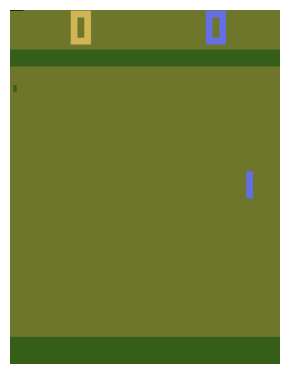

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import gymnasium as gym

env_name = "PongNoFrameskip-v4"
#env_name ="BreakoutNoFrameskip-v4"
#env_name = "SpaceInvadersNoFrameskip-v4"

env = gym.make(env_name)
state, _ = env.reset()

display("Las acciones de este ambiente:", env.unwrapped.get_action_meanings())
display("La dimensión del estado:", state.shape)

fig, ax = plt.subplots(figsize=(3, 4), tight_layout=True)
ax.axis('off')
ax.imshow(state);

El estado es una imagen de 210 x 160 x 3 pixeles

Para facilitar el entrenamiento se recomienda hacer un preprocesamiento como el que sigue

1. (opcional) Descartar parte de la imagen que no aporta información
1. Reescalar la imagen a un menor tamaño
1. Combinar los canales y generar una imagen de escala de grises
1. Crear un stack de cuatro frames como representación del estado
1. Convertir los pixeles a float y normalizar al rango [0, 1]

Para esto usaremos la librería *torchvision* y los *wrappers* de OpenAI

Tamaño del tensor transformado: (torch.Size([4, 84, 84]), torch.float32)


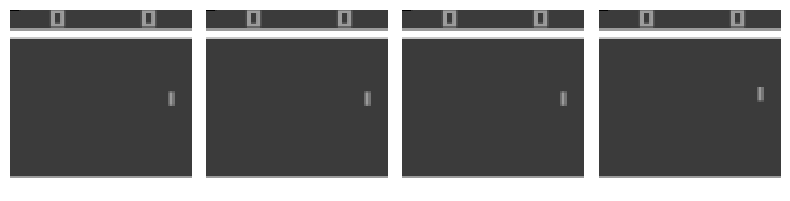

In [47]:
import numpy as np
import torch
from gymnasium.wrappers import AtariPreprocessing, FrameStack

def wrap_env(env, skip=4, k=4):
    env = EpisodicLifeEnv(env) # Perder una vida es equivalente a perder el episodio
    env = FireResetEnv(env) # Hace un disparo al inicio (algunos juegos lo necesitan)
    env = WarpFrame(env) # Crop, resize y conversión a escala de  grises
    env = ClipRewardEnv(env) # La recompensa se corta en [-1, 1] (mejora la estabilidad)
    env = FrameStack(env, k=k) # El ambiente entrega de a 4 frames    
    return env

env = FrameStack(AtariPreprocessing(gym.make(env_name), 
                                    noop_max=30, 
                                    frame_skip=4, 
                                    screen_size=84, 
                                    terminal_on_life_loss=False), num_stack=4)
env.reset()
state, _, _, _, _ = env.step(2)

def transform_state(state):
    return torch.from_numpy(np.array(state).astype('float32'))

transformed_state = transform_state(state)
print(f"Tamaño del tensor transformado: {transformed_state.shape, transformed_state.dtype}")
fig, ax = plt.subplots(1, 4, figsize=(8, 5), tight_layout=True)
for k in range(4):
    ax[k].matshow(transformed_state[k, :, :].numpy(), cmap=plt.cm.Greys_r);
    ax[k].axis('off')

**Red convolucional para estimar la función Q**

In [32]:
class ConvolutionalNeuralNetwork(torch.nn.Module):    
    def __init__(self, n_input, n_output, n_filters=32, n_hidden=256):
        super(type(self), self).__init__()
        self.conv1 = torch.nn.Conv2d(n_input, n_filters, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(n_filters, n_filters, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(n_filters, n_filters, kernel_size=3, stride=1)
        self.linear1 = torch.nn.Linear(7 * 7 * n_filters, n_hidden)
        self.output = torch.nn.Linear(n_hidden, n_output)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x):
        h = self.activation(self.conv1(x))
        h = self.activation(self.conv2(h))
        h = self.activation(self.conv3(h))
        h = h.view(-1, 7*7*32)
        h = self.activation(self.linear1(h))
        return  self.output(h)

**Replay Memory**

In [33]:
class ReplayMemory:
    
    def __init__(self, state_dim, memory_length=2000): 
        self.length = memory_length
        self.pointer = 0
        self.filled = False
        # Tensores vacíos para la historia
        self.s_current = torch.zeros((memory_length,) + state_dim)
        self.s_future = torch.zeros((memory_length,) + state_dim)
        self.a = torch.zeros(memory_length, 1, dtype=int)
        self.r = torch.zeros(memory_length, 1)
        # Adicionalmente guardaremos la condición de término
        self.end = torch.zeros(memory_length, 1, dtype=bool)
    
    def push(self, s_current, s_future, a, r, end):
        # Agregamos una tupla en la memoria
        self.s_current[self.pointer] = s_current
        self.s_future[self.pointer] = s_future
        self.a[self.pointer] = a
        self.r[self.pointer] = r 
        self.end[self.pointer] = end
        if self.pointer + 1 == self.length:
            self.filled = True
        self.pointer =  (self.pointer + 1) % self.length
        
    def sample(self, size=64):        
        # Extraemos una muestra aleatoria de la memoria
        if self.filled:
            idx = np.random.choice(self.length, size)
        elif self.pointer > size:
            idx = np.random.choice(self.pointer, size)
        else:
            return None        
        return self.s_current[idx], self.s_future[idx], self.a[idx], self.r[idx], self.end[idx]    
    

## Agente DQN

Detalles prácticos a considerar

- **Huber Loss:** Combinación del error cuadrático y el error absoluto. Se usa el error cuadrático para errores pequeños y el error absoluto para errores grandes. Mejora la estabilidad numérica del algoritmo
- **Gradient clipping:** Limitar el gradiente en un rango [mínimo, máximo], usualmente $[0,1]$. También se puede limitar dividiendo por la norma

In [34]:
import copy
    
class DeepQNetwork:
    def __init__(self, q_model, gamma=0.99, double_dqn=False, learning_rate=1e-3, 
                 target_update_freq=500, clip_grads=True, clip_error=False, huber=False):
        self.double_dqn = double_dqn
        self.gamma = gamma
        self.q_policy = q_model
        self.n_output = q_model.output.out_features
        self.clip_error = clip_error
        self.clip_grads = clip_grads
        self.update_counter = 0
        self.target_update_freq = target_update_freq
        if not huber:
            self.criterion = torch.nn.MSELoss()
        else:
            self.criterion = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.RMSprop(self.q_policy.parameters(), lr=learning_rate)
        
        if double_dqn:
            self.q_target = copy.deepcopy(self.q_policy)
            self.q_target.eval()
    
    def select_action(self, state, epsilon=0.):
        # Estrategia epsilon greedy para seleccionar acción
        if torch.rand(1).item() < 1. - epsilon: 
            self.q_policy.eval()
            with torch.no_grad():
                q = self.q_policy(state)[0]
                a = q.argmax().item()
                q = q[a]
            self.q_policy.train()
        else:
            q = None
            a = torch.randint(high=self.n_output, size=(1,)).item() 
        
        return a, q
    
    def update(self, mini_batch):
        self.update_counter += 1
        state, state_next, action, reward, end = mini_batch
        # Calcular Q
        q_current = self.q_policy(state).gather(1, action)
        with torch.no_grad():
            if not self.double_dqn:
                q_next_best = self.q_policy(state_next).max(1, keepdim=True)[0]
            else:
                action_next = self.q_policy(state_next).argmax(dim=1, keepdim=True)
                q_next_best = self.q_target(state_next).gather(1, action_next)               
        # Construir el target: r + gamma*max Q(s', a')
        td_target = reward
        td_target[~end] += self.gamma*q_next_best[~end]
        td_target[end] = -1.
        # Calcular pérdido y sus gradientes
        self.optimizer.zero_grad()
        loss = self.criterion(q_current, td_target)
        if self.clip_error:
            loss.clamp_(-1., 1.)
        loss.backward()
        # Cortar gradientes grandes (mejora la estabilidad)
        if self.clip_grads:
            for param in self.q_policy.parameters():
                param.grad.data.clamp_(-1., 1.)
            #torch.nn.utils.clip_grad.clip_grad_norm_(self.q_policy.parameters(), 10)
        # Actualizar
        self.optimizer.step()
        # Transfer policy to target
        self.transfer_policy2target()
        # Retornar el valor de la loss
        return loss.item()
    
    def transfer_policy2target(self):
        if self.double_dqn:            
            if self.update_counter % self.target_update_freq == 0:
                self.q_target.load_state_dict(self.q_policy.state_dict())
                return True
        return False

## Gráficas de aprendizaje

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.signal import convolve

fig, ax = plt.subplots(4, figsize=(6, 5), sharex=True, tight_layout=True)

def smooth_data(x, window_length=10):
    return convolve(x, np.ones(window_length)/window_length, mode='valid')

def update_plot(step, episode, smooth_window=10, target=None):
    for ax_ in ax:
        ax_.cla()
    episodes = np.arange((episode))
    ax[0].scatter(episodes, diagnostics['rewards'], s=1)      
    if episode > smooth_window:
        ax[0].plot(episodes[:-smooth_window+1], 
                   smooth_data(diagnostics['rewards']), alpha=0.5, lw=2)        
    ax[1].plot(episodes, diagnostics['loss'])
    ax[2].plot(episodes, np.array(diagnostics['q_sum'])/(np.array(diagnostics['q_N'])+1e-4))
    if not target is None:               
        ax[0].plot(episodes, [target]*len(episodes), 'k--')
    ax[0].set_ylabel('Recompensa');
    ax[1].set_ylabel('Loss')
    ax[2].set_ylabel('Q promedio')
    ax[3].plot(episodes, epsilon(episodes))
    ax[3].set_ylabel('Epsilon')
    ax[3].set_xlabel('Episodios')
    ax[0].set_title("Paso %d" % (step))
    fig.canvas.draw()

## Entrenamiento del agente

In [48]:
from tqdm.notebook import tqdm

torch.manual_seed(1234)
np.random.seed(1234)
n_state = (4, 84, 84)
n_action = env.action_space.n 

dqn_model = DeepQNetwork(q_model=ConvolutionalNeuralNetwork(n_state[0], n_action),
                         gamma = 0.99,
                         double_dqn=True,
                         target_update_freq=1000,
                         learning_rate=1e-4, huber=True)

def epsilon(episode, epsilon_init=0.1, epsilon_end=0.01, epsilon_rate=1e-2):
    return epsilon_end + (epsilon_init - epsilon_end) * np.exp(-epsilon_rate*episode) 

memory = ReplayMemory(n_state, memory_length=10000)        

diagnostics = {'rewards': [0], 'loss': [0],
               'q_sum': [0], 'q_N': [0]}

episode = 1
terminated, truncated = False, False
stacked_states, _ = env.reset()

for step in tqdm(range(100000)):    
    # Escoger acción
    state = transform_state(stacked_states)
    a, q = dqn_model.select_action(state.unsqueeze(0), epsilon(episode))
    if q is not None:
        diagnostics['q_sum'][-1] += q
        diagnostics['q_N'][-1] += 1
    
    # Aplicar la acción 
    stacked_states_next, r, terminated, truncated, info = env.step(a)  
    diagnostics['rewards'][-1] += r
    # Guardar en memoria
    memory.push(state, transform_state(stacked_states_next), 
                a, torch.tensor(r), terminated)
    
    stacked_states = stacked_states_next
    
    # Actualizar modelo    
    mini_batch = memory.sample(32)
    if not mini_batch is None:
        diagnostics['loss'][-1] += dqn_model.update(mini_batch)            
    
    # Preparar siguiente episodio
    if terminated or truncated:
        if episode % 5 == 0:
            update_plot(step, episode)
        episode += 1   
        terminated = False
        stacked_states, _ = env.reset()
        diagnostics['rewards'].append(0)
        diagnostics['loss'].append(0)
        diagnostics['q_sum'].append(0)
        diagnostics['q_N'].append(0)

  0%|          | 0/100000 [00:00<?, ?it/s]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

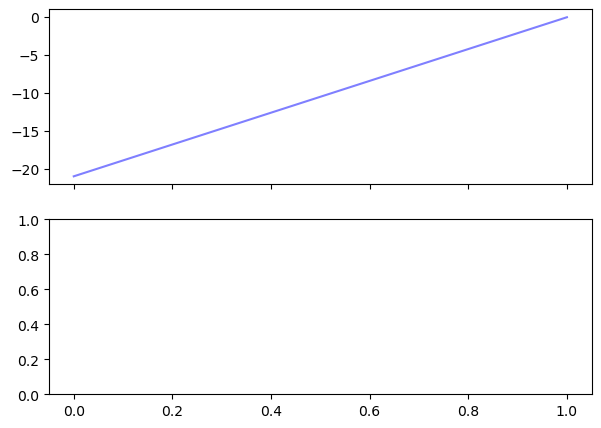

In [51]:
from scipy.signal import savgol_filter

fig, ax = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
for ax_, (key, val) in zip(ax, diagnostics.items()):
    ax_.plot(val, alpha=0.5, c='b')
    ax_.plot(savgol_filter(val, 50, 1), c='b')
    ax_.set_ylabel(key)
ax_.set_xlabel('Episode');

## Guardar el agente para futura referencia y evaluar

In [50]:
env.reset()

(<gymnasium.wrappers.frame_stack.LazyFrames at 0x7fb08fb90720>,
 {'lives': 0, 'episode_frame_number': 13, 'frame_number': 3932})

In [ ]:
import pickle

with open("mi_modelo.pkl", "wb") as f:
    pickle.dump([dqn_model, dqn_model.q_policy.state_dict()], f)

In [ ]:
import gym
from time import sleep

env = wrap_env(gym.make(env_name), skip=1)
stacked_states = env.reset()
end = False

while not end:
    state = preprocess(stacked_states)
    a, q = dqn_model.select_action(state.unsqueeze(0))
    stacked_states, r, end, info = env.step(a)
    env.render() 
    sleep(.01)     

## Agentes artesanales pre-entrenados 

In [ ]:
import pickle
# Estos agentes corresponden a la última iteración, 
# pero en realidad debería grabarse el que obtiene mejor recompensa 

# Pong entrenado durante 200_000 pasos con memoria de 10_000, aprox 2hrs de entrenamiento
env_name = "PongNoFrameskip-v4"
with open("modelos/pong_masomenos.pkl", "rb") as f:
    dqn_model_loaded, q_policy_state_dict_loaded = pickle.load(f)

In [ ]:
import gym
from time import sleep

random_agent = False
env = wrap_env(gym.make(env_name), skip=1)
stacked_states = env.reset()
end = False

while not end:
    if not random_agent:
        state = preprocess(stacked_states)
        a, q = dqn_model_loaded.select_action(state.unsqueeze(0))
    else:
        a = env.action_space.sample()
    stacked_states, r, end, info = env.step(a)
    env.render() 
    sleep(.01)     

In [ ]:
env.close()